<a href="https://colab.research.google.com/github/cjkreienkamp/machine-learning-notebooks/blob/main/02_tabular_data_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [ ]:
import sys
import torch
import cv2
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data preparation

In [ ]:
!pip install ucimlrepo > /dev/null

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X_df = breast_cancer_wisconsin_diagnostic.data.features
y_df = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [17]:
print(X_df.info(), y_df.info())
X_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

Index(['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3'],
      dtype='object')

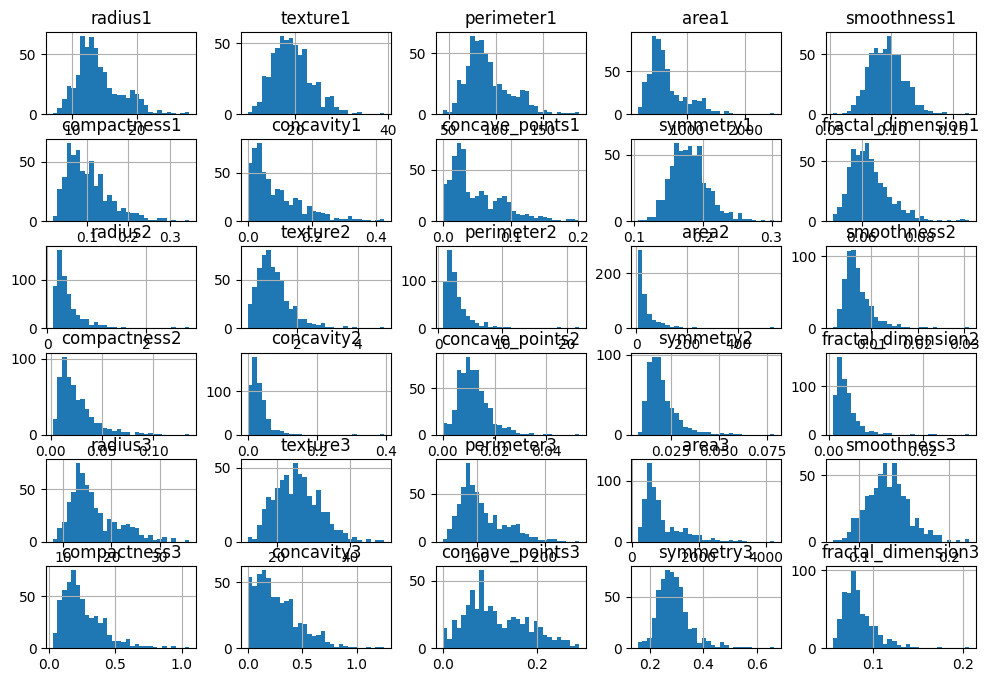

In [18]:
X_df.hist(figsize=(12,8), bins=30)
plt.show()

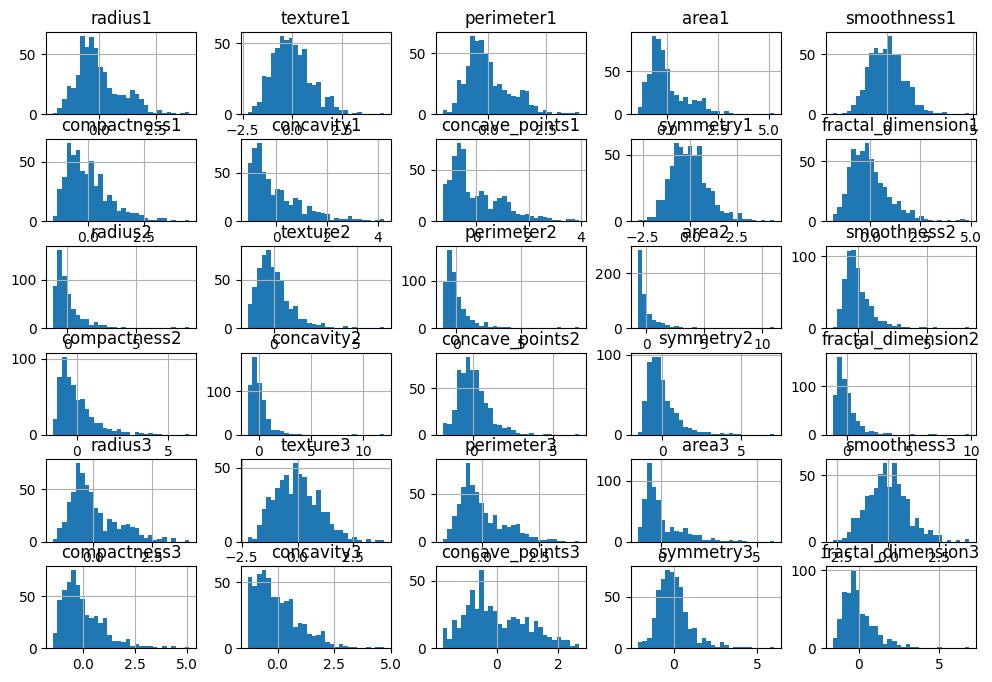

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(X_df), columns=X_df.columns)
df_standardized.hist(figsize=(12,8), bins=30)
plt.show()

In [ ]:
X_train, X_temp, y_train, y_temp  = train_test_split(X_df, y_df, test_size=0.20, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=True)

In [27]:
class BreastCancerDataset(Dataset):
    def __init__(self, X_df, y_df):

        # feature engineer
        # drop unwanted inputs
        # fill empty inputs
        # min max scale continuous values
        # one-hot encode categorical values
        # separate targets from inputs (if not already done so)
        # turn targets into a classification value

        scaler = StandardScaler()
        df_standardized = pd.DataFrame(scaler.fit_transform(X_df), columns=X_df.columns)

        y_df['Diagnosis'] = (y_df['Diagnosis'] == 'M').astype(int)

        self.X = df_standardized.values.astype(np.float32)
        self.y = y_df.values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return torch.tensor(self.X[index]), torch.tensor(self.y[index])

In [28]:
train_dataset = BreastCancerDataset(X_train, y_train)
valid_dataset = BreastCancerDataset(X_valid, y_valid)
test_dataset = BreastCancerDataset(X_test, y_test)

In [36]:
torch.manual_seed(42)
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

for x1, y1 in valid_loader:
    print(x1.shape, y1.shape)
    break

print(len(train_dataset), len(valid_dataset), len(test_dataset))

torch.Size([128, 30]) torch.Size([128, 1])
torch.Size([57, 30]) torch.Size([57, 1])
455 57 57


# Model training

In [45]:
import torch.nn as nn
from torchsummary import summary

In [52]:
import numpy as np

def dataloader_to_numpy(data_loader):
    X_list, y_list = [], []

    for X_batch, y_batch in data_loader:
        X_list.append(X_batch.numpy())  # Convert tensors to NumPy
        y_list.append(y_batch.numpy())

    X_array = np.vstack(X_list)  # Stack batches into one array
    y_array = np.concatenate(y_list)
    return X_array, y_array

X_train, y_train = dataloader_to_numpy(train_loader)
X_val, y_val = dataloader_to_numpy(valid_loader)

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate on validation set
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")


Random Forest Accuracy: 0.9649


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [54]:
class BreastCancerNN(nn.Module):
    def __init__(self, input_size):
        super(BreastCancerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, out_features=64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

for x, y in train_loader:
    break
print(f"Input size: {x.shape}")
summary(BreastCancerNN(x.shape[1]), x.shape)

Input size: torch.Size([128, 30])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 128, 64]           1,984
            Linear-2              [-1, 128, 32]           2,080
            Linear-3               [-1, 128, 1]              33
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.02
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [65]:
def train_fn(data_loader, model, optimizer):

    total_loss, total_correct, total_samples = 0.0, 0, 0

    model.train()

    for X, y in data_loader:

        X = X.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(X)
        predictions = torch.round(torch.sigmoid(logits))

        loss = loss_fn(logits, y)
        total_loss += loss.item()
        total_correct += (predictions == y).sum().item()
        total_samples += len(y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader) , total_correct / total_samples * 100

def eval_fn(data_loader, model):

    total_loss, total_correct, total_samples = 0.0, 0, 0

    model.eval()

    with torch.inference_mode():

        for X, y in data_loader:

            X = X.to(DEVICE)
            y = y.to(DEVICE)

            logits = model(X)
            predictions = torch.round(torch.sigmoid(logits))

            loss = loss_fn(logits, y)
            total_loss += loss.item()
            total_correct += (predictions == y).sum().item()
            total_samples += len(y)

        return total_loss / len(data_loader), total_correct / total_samples * 100

In [66]:
EPOCHS = 1500
LEARNING_RATE = 0.0001
L2_REG = 1e-4

loss_fn = nn.BCEWithLogitsLoss()

In [67]:
model = BreastCancerNN(x.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)

epoch_count, train_loss_values, valid_loss_values = [], [], []
train_acc_values, valid_acc_values = [], []
best_valid_loss = np.Inf

for epoch in range(EPOCHS):

    train_loss, train_accuracy = train_fn(train_loader, model, optimizer)
    valid_loss, valid_accuracy = eval_fn(valid_loader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_valid_loss = valid_loss

    if epoch % int(EPOCHS / 20) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {train_loss:.5f}, Accuracy: {train_accuracy:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_accuracy:.2f}%')
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        valid_loss_values.append(valid_loss)
        train_acc_values.append(train_accuracy)
        valid_acc_values.append(valid_accuracy)


Epoch:    0 | Train Loss: 0.70241, Accuracy: 36.48% | Validation Loss: 0.70164, Accuracy: 36.84%
Epoch:   75 | Train Loss: 0.31351, Accuracy: 95.38% | Validation Loss: 0.30006, Accuracy: 94.74%
Epoch:  150 | Train Loss: 0.11998, Accuracy: 97.80% | Validation Loss: 0.11636, Accuracy: 94.74%
Epoch:  225 | Train Loss: 0.07894, Accuracy: 98.68% | Validation Loss: 0.08217, Accuracy: 98.25%
Epoch:  300 | Train Loss: 0.05510, Accuracy: 98.90% | Validation Loss: 0.07351, Accuracy: 98.25%
Epoch:  375 | Train Loss: 0.04432, Accuracy: 98.90% | Validation Loss: 0.07197, Accuracy: 98.25%
Epoch:  450 | Train Loss: 0.03605, Accuracy: 99.12% | Validation Loss: 0.07428, Accuracy: 98.25%
Epoch:  525 | Train Loss: 0.03108, Accuracy: 99.34% | Validation Loss: 0.07820, Accuracy: 98.25%
Epoch:  600 | Train Loss: 0.02494, Accuracy: 99.34% | Validation Loss: 0.08302, Accuracy: 98.25%
Epoch:  675 | Train Loss: 0.02006, Accuracy: 99.34% | Validation Loss: 0.08922, Accuracy: 98.25%
Epoch:  750 | Train Loss: 0.01

# Model evaluation

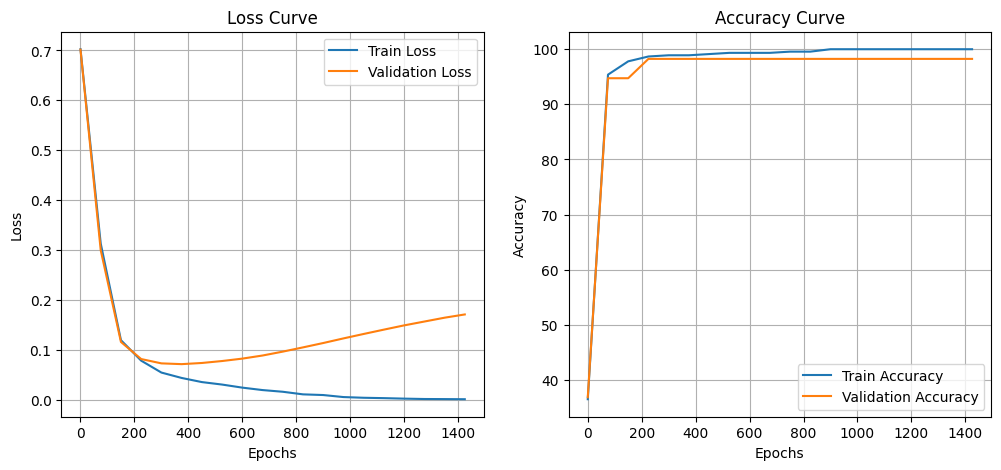

In [68]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(epoch_count, train_loss_values, train_acc_values, valid_loss_values, valid_acc_values):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Loss Curve
    axes[0].plot(epoch_count, train_loss_values, label='Train Loss')
    axes[0].plot(epoch_count, valid_loss_values, label='Validation Loss')
    axes[0].set_title('Loss Curve')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Accuracy Curve
    axes[1].plot(epoch_count, train_acc_values, label='Train Accuracy')
    axes[1].plot(epoch_count, valid_acc_values, label='Validation Accuracy')
    axes[1].set_title('Accuracy Curve')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.show()

# Example Usage
plot_loss_accuracy(epoch_count, train_loss_values, train_acc_values, valid_loss_values, valid_acc_values)

In [69]:
test_loss, test_accuracy = eval_fn(test_loader, model)
print(f'Test Loss: {test_loss:.5f}, Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.03772, Accuracy: 98.25%


In [70]:
for x_test, y_test in test_loader:
    break

model.eval()

with torch.inference_mode():
    test_logits = model(x_test.to(DEVICE)).squeeze()
    test_predictions = torch.round(torch.sigmoid(test_logits)).int()

In [76]:
y_test.squeeze(1).int(), test_predictions

(tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
         0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32),
 tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
         0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32))